__Домашняя работа 4.__

In [1]:
# !pip install scikit-uplift==0.2.0

In [2]:
%matplotlib inline
import numpy as np
import pandas as pd; #pd.set_option('display.max_columns', None)
from sklearn.model_selection import train_test_split

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, train_test_split
from scipy.sparse import hstack
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import Normalizer

import matplotlib.pyplot as plt

In [3]:
def min_max_scale(X):
    return (X - X.min()) / (X.max() - X.min())

__Задание 1.__ Скачать данные

In [4]:
df = pd.read_csv('HW_data.csv', sep=',')

In [5]:
df

,recency,history,used_discount,used_bogo,zip_code,is_referral,channel,offer,conversion
0,10,142.44,1,0,Surburban,0,Phone,Buy One Get One,0
1,6,329.08,1,1,Rural,1,Web,No Offer,0
2,7,180.65,0,1,Surburban,1,Web,Buy One Get One,0
3,9,675.83,1,0,Rural,1,Web,Discount,0
4,2,45.34,1,0,Urban,0,Web,Buy One Get One,0
...,...,...,...,...,...,...,...,...,...
63995,10,105.54,1,0,Urban,0,Web,Discount,0
63996,5,38.91,0,1,Urban,1,Phone,Discount,0
63997,6,29.99,1,0,Urban,1,Phone,Discount,0
63998,1,552.94,1,0,Surburban,1,Multichannel,Buy One Get One,0


__Задание 2.__ Поле conversion - это целевая переменная, а offer - коммуникация. Переименовать поля (conversion -> target, offer -> treatment) и привести поле treatment к бинарному виду (1 или 0, т.е было какое-то предложение или нет) - значение No Offer означает отсутствие коммуникации, а все остальные - наличие.

In [6]:
df.rename(columns={'conversion': 'target', 'offer': 'treatment'}, inplace=True)

In [7]:
print(pd.unique(df['treatment']))

['Buy One Get One' 'No Offer' 'Discount']


In [8]:
df['treatment'] = np.where(df['treatment'] == 'No Offer', 0, 1)

In [9]:
print(pd.unique(df['treatment']))

[1 0]


__Задание 3.__ Сделать разбиение набора данных на тренировочную и тестовую выборки

In [10]:
X_train, X_test, y_train, y_test = train_test_split(df.drop('target', 1), 
                                                    df['target'], random_state=0)

__Задание 4.__ Сделать feature engineering на ваше усмотрение (допускается свобода выбора методов)

In [11]:
print(pd.unique(df['channel']))

['Phone' 'Web' 'Multichannel']


In [12]:
dct = {'Phone':0, 'Web':1, 'Multichannel':2}
df['channel'] = df['channel'].map(dct)

In [13]:
print(pd.unique(df['channel']))

[0 1 2]


In [14]:
print(pd.unique(df['zip_code']))

['Surburban' 'Rural' 'Urban']


In [15]:
dct = {'Surburban':0, 'Rural':1, 'Urban':2}
df['zip_code'] = df['zip_code'].map(dct)

In [16]:
for i in df.columns:
    print(f'{i}: {pd.unique(df[i])}')

recency: [10  6  7  9  2  1  5  4  3 11 12  8]
history: [142.44 329.08 180.65 ... 519.69 105.54 552.94]
used_discount: [1 0]
used_bogo: [0 1]
zip_code: [0 1 2]
is_referral: [0 1]
channel: [0 1 2]
treatment: [1 0]
target: [0 1]


In [17]:
df['history'].min()

29.99

In [18]:
df['history'].max()

3345.93

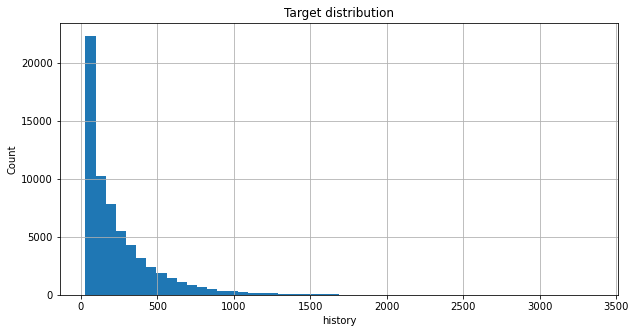

In [19]:
plt.figure(figsize = (10, 5))

df['history'].hist(bins=50)
plt.ylabel('Count')
plt.xlabel('history')
plt.title('Target distribution');

In [20]:
 df[df['history'] > 2000].count() 

recency          42
history          42
used_discount    42
used_bogo        42
zip_code         42
is_referral      42
channel          42
treatment        42
target           42
dtype: int64

In [21]:
df = df.drop(np.where(df['history'] > 2000)[0]) # существует очень мало элементов столбца history выше 2000, поэтому будет считать их за выбросы и удалим
df

,recency,history,used_discount,used_bogo,zip_code,is_referral,channel,treatment,target
0,10,142.44,1,0,0,0,0,1,0
1,6,329.08,1,1,1,1,1,0,0
2,7,180.65,0,1,0,1,1,1,0
3,9,675.83,1,0,1,1,1,1,0
4,2,45.34,1,0,2,0,1,1,0
...,...,...,...,...,...,...,...,...,...
63995,10,105.54,1,0,2,0,1,1,0
63996,5,38.91,0,1,2,1,0,1,0
63997,6,29.99,1,0,2,1,0,1,0
63998,1,552.94,1,0,0,1,2,1,0


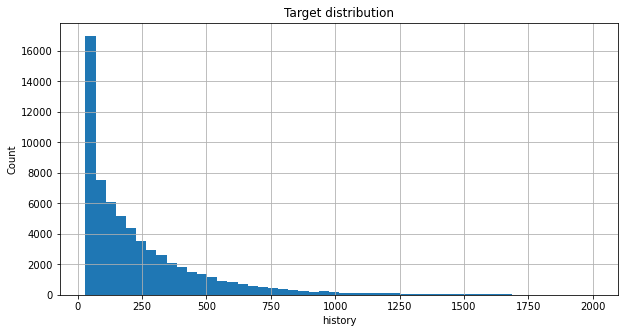

In [22]:
plt.figure(figsize = (10, 5))

df['history'].hist(bins=50)
plt.ylabel('Count')
plt.xlabel('history')
plt.title('Target distribution');

In [23]:
#transformer = Normalizer() # я так и не понял как это работает, поэтому старым методом сделал) 
#transformer.fit_transform(df['history'])

In [24]:
df['history'] = min_max_scale(df['history']) # нормализуем

In [25]:
df['recency'] = min_max_scale(df['recency'])

In [26]:
print(pd.unique(df['target']))

[0 1]


In [27]:
# еще раз разобьем измененные данные на train и test
X_train, X_test, y_train, y_test = train_test_split(df.drop('target', 1), 
                                                    df['target'], random_state=0)

In [28]:
cat_features = ['zip_code', 'channel']

In [29]:
#indices_learn, indices_valid = train_test_split(df.index, test_size=0.3, random_state=123)

In [35]:
y_test

54992    1
34794    0
8090     0
23783    0
52775    0
        ..
5053     0
60282    0
29455    0
5729     1
40717    1
Name: target, Length: 15990, dtype: int64

In [37]:
treat_train = X_train['treatment']
treat_test = X_test['treatment']
treat_test

54992    1
34794    0
8090     1
23783    1
52775    0
        ..
5053     1
60282    1
29455    1
5729     1
40717    1
Name: treatment, Length: 15990, dtype: int32

__Задание 5.__ Провести uplift-моделирование 3 способами: одна модель с признаком коммуникации (S learner), модель с трансформацией таргета (трансформация классов п. 2. 1) и вариант с двумя независимыми моделями

In [38]:
# Инструкция по установке пакета: https://github.com/maks-sh/scikit-uplift
# Ссылка на документацию: https://scikit-uplift.readthedocs.io/en/latest/
from sklift.metrics import uplift_at_k
from sklift.viz import plot_uplift_preds
from sklift.models import SoloModel

# sklift поддерживает любые модели, 
# которые удовлетворяют соглашениями scikit-learn
# Для примера воспользуемся catboost
from catboost import CatBoostClassifier

In [44]:
models_results = {
    'approach': [],
    'uplift@30%': []
}

In [39]:
sm = SoloModel(CatBoostClassifier(iterations=20, thread_count=2, random_state=42, silent=True))
sm = sm.fit(X_train, y_train, treat_train, estimator_fit_params={'cat_features': cat_features})

uplift_sm = sm.predict(X_test)

uplift@30%: 0.0817


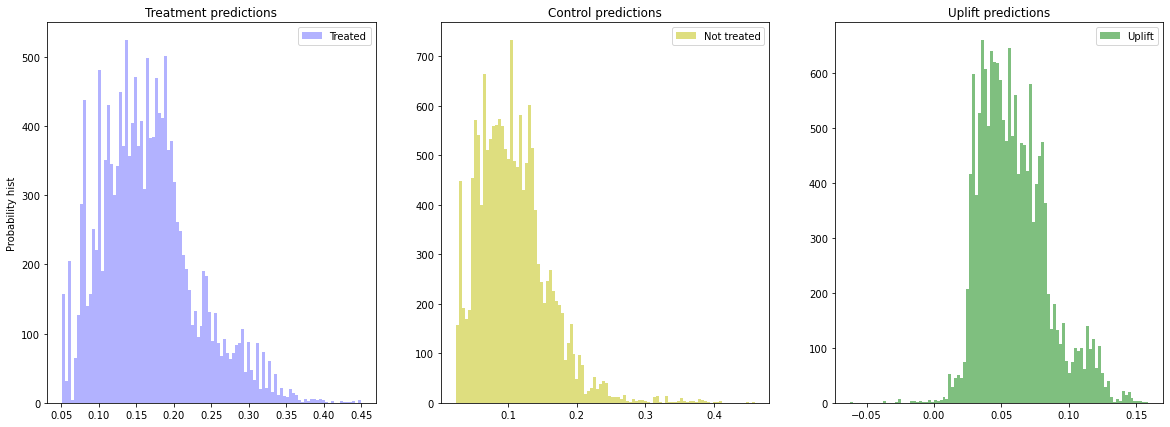

In [45]:
sm_score = uplift_at_k(y_true=y_test, uplift=uplift_sm, treatment=treat_test, strategy='by_group', k=0.3)
print(f'uplift@30%: {sm_score:.4f}')

models_results['approach'].append('SoloModel')
models_results['uplift@30%'].append(sm_score)

# Получим условные вероятности выполнения целевого действия при взаимодействии для каждого объекта
sm_trmnt_preds = sm.trmnt_preds_
# И условные вероятности выполнения целевого действия без взаимодействия для каждого объекта
sm_ctrl_preds = sm.ctrl_preds_

# Отрисуем распределения вероятностей и их разность (uplift)
plot_uplift_preds(trmnt_preds=sm_trmnt_preds, ctrl_preds=sm_ctrl_preds);

__Задание 6.__ В конце вывести единую таблицу сравнения метрик uplift@10%, uplift@20% этих 3 моделей

Больше сделать не успел)